In [1]:
import onnx
import os
import wandb
import onnxruntime as ort
import numpy as np
from utils_tbm import *
from test_tbm import test as evals

In [2]:
model = onnx.load(os.getcwd()+"/model.onnx")
(onnx.checker.check_model(model))

In [ ]:
print(model)

In [4]:
train_data, _ = get_data_from_csv('../../preprocessed.csv', train=True)
test_data, _ = get_data_from_csv('../../preprocessed.csv', train=False)
test_loader = make_loader(test_data, batch_size=1)

In [5]:
remote_hosts = get_test_remote_hosts('../../preprocessed.csv')

In [6]:
print(len(remote_hosts))

4015


In [7]:
import re
values_reconstruction = []
with open('reconstructions.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        values = re.findall(r'\d+\.\d+e?-?\d*', line)
        # Convert the string values to floats
        values_reconstruction.append(float(values[0]))
        

In [8]:
dict_reconstruction = dict()
for i in range(len(remote_hosts)):
    dict_reconstruction[remote_hosts[i]] = values_reconstruction[i]
max(dict_reconstruction.values())

0.0578029528260231

In [9]:
import matplotlib.pyplot as plt

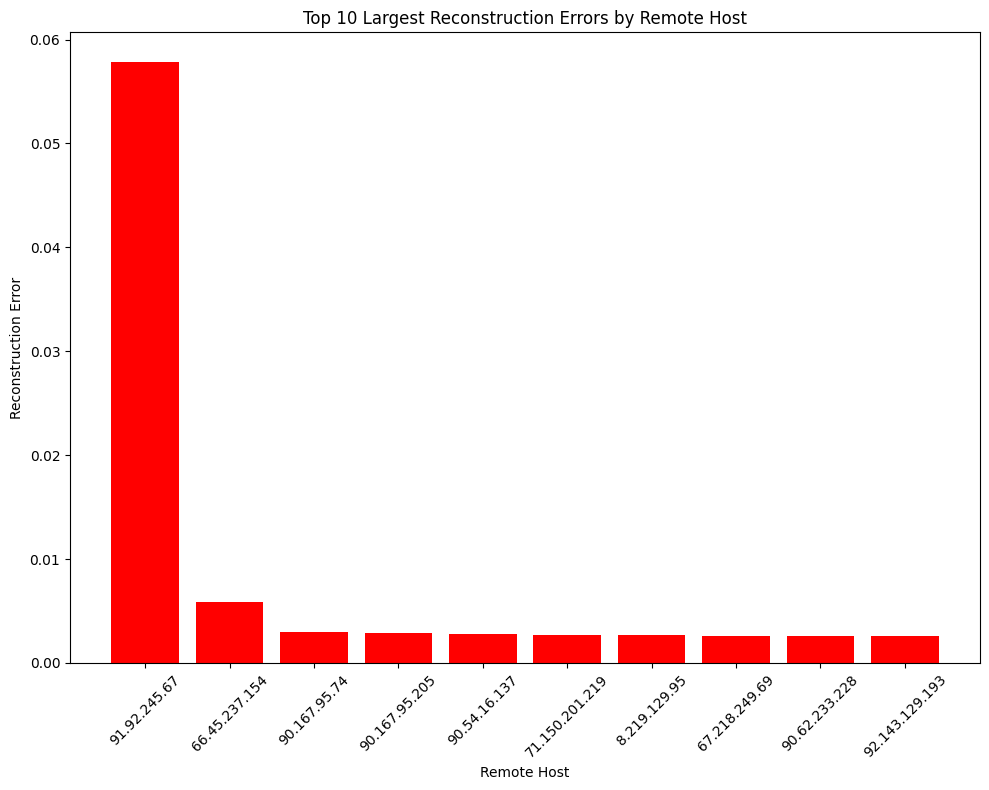

In [10]:
df = pd.DataFrame(list(dict_reconstruction.items()), columns=['Remote Host', 'Reconstruction Error']).sort_values(by='Reconstruction Error', ascending=False)

# select the top 10 records with the largest reconstruction errors
top_10_df = df.head(10)

# plotting
plt.figure(figsize=(10, 8))
plt.bar(top_10_df['Remote Host'], top_10_df['Reconstruction Error'], color = 'red')
plt.xlabel('Remote Host')
plt.ylabel('Reconstruction Error')
plt.title('Top 10 Largest Reconstruction Errors by Remote Host')
plt.xticks(rotation=45)  # rotate x-axis labels for readability
plt.tight_layout()

plt.show()